# DISTILED MODEL

### Дистилляция - способ обучения новой модели, сохраненющий качество модели, при этом уменьшеная количество параметров. При обучение ответы модели-ученика сравниваются с ответами модели-учителя, которая является той, которую, как раз таки, мы хотим дистиллировать (уменьшить, сохранив качество).


### Дистиллировать будем Stable Diffusion XL. Протестируем разные версии дистилляции этой модели

In [ ]:
!pip install diffusers -q

from diffusers import AutoPipelineForText2Image
import torch
from diffusers import DiffusionPipeline

pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype = torch.float16, variant = "fp16")
pipeline = DiffusionPipeline.from_pretrained("segmind/small-sd", torch_dtype=torch.float16)
pipeline = pipeline.to('cuda')

  0%|          | 0/50 [00:00<?, ?it/s]

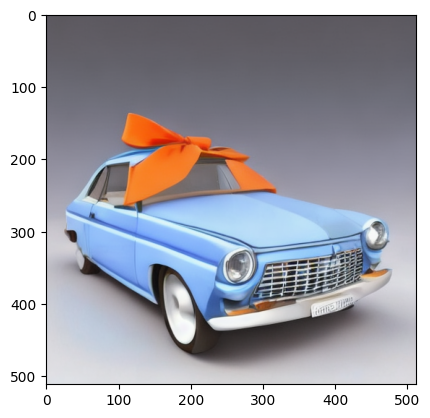

In [36]:
prompt = "Create a 3D unrealistic cartoon-style image on a white background. The image should be simple for cutting out an object and not too detailed. Blue car with orange bow"
image = pipeline(prompt).images[0]
image.save("my_image.png")

import matplotlib.pyplot as plt

plt.imshow(image)

In [ ]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("nota-ai/bk-sdm-small", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

  0%|          | 0/50 [00:00<?, ?it/s]

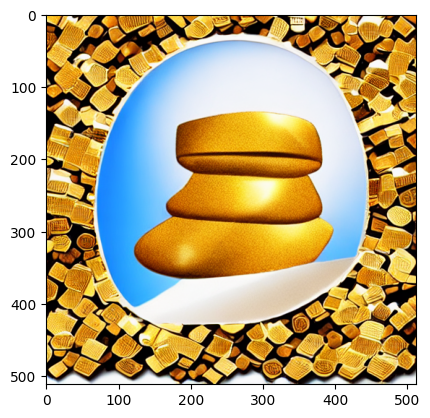

In [14]:
prompt = "Create a 3D unrealistic cartoon-style image on a white background. The image should be simple for cutting out an object and not too detailed. Stack of gold coins"
image = pipe(prompt).images[0]  

plt.imshow(image)

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline, DPMSolverSinglestepScheduler

pipe = StableDiffusionXLPipeline.from_pretrained("sd-community/sdxl-flash", torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DPMSolverSinglestepScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

  0%|          | 0/5 [00:00<?, ?it/s]

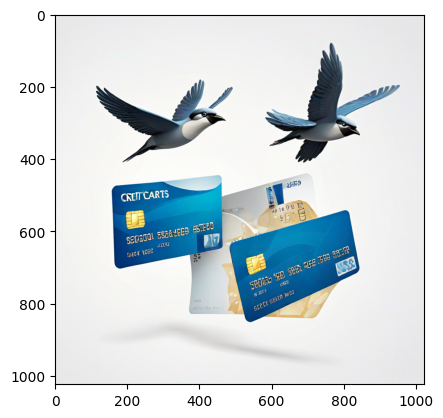

In [33]:
prompt = "Create a 3D unrealistic cartoon-style image on a white background. The image should be simple for cutting out an object and not too detailed. Hous"
image = pipe(prompt, num_inference_steps = 5, guidance_scale = 3).images[0]
plt.imshow(image)

In [ ]:
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = "sdxl_lightning_4step_unet.safetensors"

unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cuda", torch.float16)
unet.load_state_dict(load_file(hf_hub_download(repo, ckpt), device="cuda"))
pipe = StableDiffusionXLPipeline.from_pretrained(base, unet=unet, torch_dtype=torch.float16, variant="fp16").to("cuda")

pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

  0%|          | 0/4 [00:00<?, ?it/s]

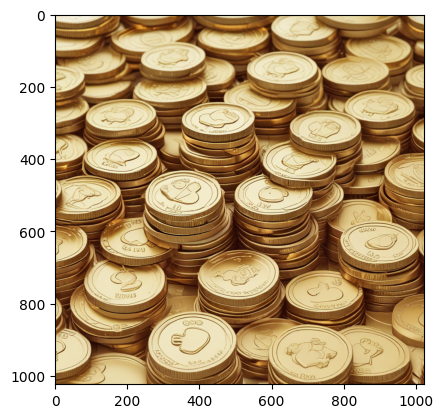

In [4]:
prompt = "Create a 3D unrealistic cartoon-style image on a white background. The image should be simple for cutting out an object and not too detailed. Stack of gold coins"
image = pipe(prompt, num_inference_steps=4, guidance_scale=0).images[0]

import matplotlib.pyplot as plt
plt.imshow(image)

### Пока что видим, что ни одна дистяллиционная модель не дала такого качества, как мы ожидаем. Будем искать решение дальше

# СБОР ПАЙПЛАЙНА

### Посмотрим, как модель справляется с разными промптами, насколько хорошо обрезается главный объект (объекты) от фона. Соберём первичный пайплайн

In [1]:
!pip install rembg -q
!pip install diffusers -q

In [ ]:
import os
from rembg import remove
from PIL import Image
import torch
from diffusers import StableDiffusionXLPipeline, DPMSolverSinglestepScheduler, StableDiffusionPipeline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Модель дистиляционная
pipe = StableDiffusionXLPipeline.from_pretrained("sd-community/sdxl-flash", torch_dtype = torch.float16).to("cuda")
pipe.scheduler = DPMSolverSinglestepScheduler.from_config(pipe.scheduler.config, timestep_spacing = "trailing")

# Модель для лого
# pipe = StableDiffusionPipeline.from_pretrained("nicky007/stable-diffusion-logo-fine-tuned", torch_dtype = torch.float16).to("cuda")

In [4]:
def remove_bg(path_to_image):
  # if path_to_image.endswith('.png') or path_to_image.endswith('.jpg') or path_to_image.endswith('.jpeg') or path_to_image.endswith('.jpeg') or:
      output = remove(Image.open(path_to_image))
      output.save(os.path.join(f'{path_to_image.split(".")[0]}_cropped.png'))
      return output

In [36]:
def get_picture(prompt, num_pictures, detalization = 5):
    
    # МОДЕЛЬ ДИСТИЛЯЦИОННАЯ 
#     PICTURE_TYPE = 'Create a simple, flat vector icon on a white background. The image should be very minimalistic and easy to understand, resembling a basic symbol or pictogram. '

#     PICTURE_TYPE = 'Create a cartoon-style, flat, vector image on a white background. The image should be very simple and easy to cut out. The image should look like a basic icon or interface element. '

#     PICTURE_TYPE = 'Create a flat, minimalist 3D icon on a white background with no realistic details and no shadows. The image should be very simple with clean lines and minimal details, making it easy to cut out. The image should look like a basic icon or interface element. '

#     PICTURE_TYPE = 'Create a flat, minimalist 3D icon on a white background. The image should be very simple with clean lines and minimal details, making it easy to cut out. The image should look like a basic icon or interface element. '

#     PICTURE_TYPE = 'Create a isometric 3D claymorphism image on a white background. The image should be very simple for cutting out an object and not too detailed. The image should looking like icon or element of interface. '

#     PICTURE_TYPE = 'Create a flat, vector, minimalist 3D icon, isometric 3D claymorphism image on a white background with no realistic details and no shadows. The image should be very simple with clean lines and minimal details, making it easy to cut out. The image should look like a basic icon or interface element. The image should be very minimalistic and easy to understand, resembling a basic symbol or pictogram. '
  
    PICTURE_TYPE = 'Create a isometric 3D claymorphism flat vector minimalist image on a white background. The image should be very simple with clean lines and minimal details, making it easy to cut out. The image should look like a basic icon or interface element. MAKE IT VERY ICOMETRIC!!! '
    
#     PICTURE_TYPE = 'Изометрическое 3D пластилиновое векторное плоское изображение на белом фоне. Изображение должно быть очень простое и минималистичное и объект должен быть легко вырезаемым от фона. Изображение должно выглядеть как иконка или элемент интерфейса. '
    
    # МОДЕЛЬ ЛОГО 
    
#     PICTURE_TYPE = 'Isometric 3D image, claymorphism style, vertor image, flat, very simple, on a white background. '

    PROMPT = PICTURE_TYPE + prompt
    
    images, images_cropped  = [], []
    for i in range(num_pictures):
        image = pipe(prompt, num_inference_steps = detalization, guidance_scale = 0).images[0]
        PATH_SAVE = '/kaggle/working/' + prompt.split('.')[-1] + f'_{i}' + '.jpg'
        image.save(PATH_SAVE)
        images += [image]

        image_cropped = remove_bg(PATH_SAVE)
        images_cropped += [image_cropped]

    if num_pictures == 1:
        fig, axes = plt.subplots(nrows = num_pictures, ncols = 2)
        fig.set_size_inches(10, 10)
        fig.suptitle(prompt.split('.')[-1])
        axes[0].imshow(images[0])
        axes[0].set_title('Generated')
        axes[1].imshow(images_cropped[0])
        axes[1].set_title('Cropped')
    else:
        fig, axes = plt.subplots(nrows = num_pictures, ncols = 2)
        fig.set_size_inches(10, 10)
        fig.suptitle(prompt.split('.')[-1])
        for i in range(num_pictures):
            axes[i, 0].imshow(images[i])
            axes[i, 0].set_title('Generated')
            axes[i, 1].imshow(images_cropped[i])
            axes[i, 1].set_title('Cropped')
    plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

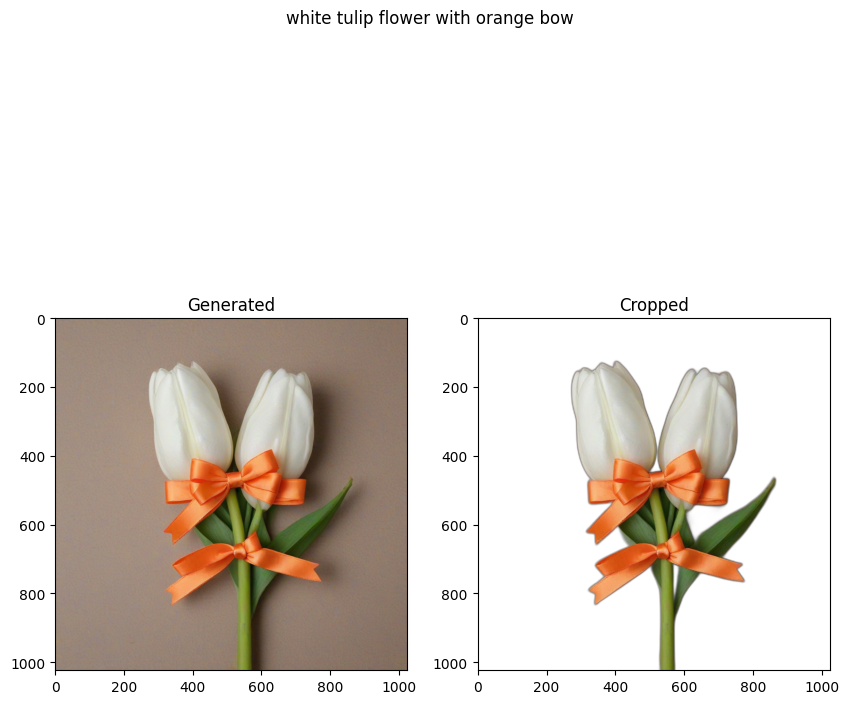

In [38]:
get_picture('white tulip flower with orange bow', num_pictures = 1, detalization = 5)

# IMAGE TO IMAGE

### Мы задумали добавить в функционал также модель Image2Image. Протестируем, посмотрим, что получается

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16)

pipe = pipe.to("cuda")

In [8]:
from rembg import remove
import numpy as np
from matplotlib import cm
from PIL import Image

def create_mask_image(PATH):
    return np.array([[[255, 255, 255] for i in range(512)] for j in range(512)]).astype(float)

  0%|          | 0/50 [00:00<?, ?it/s]

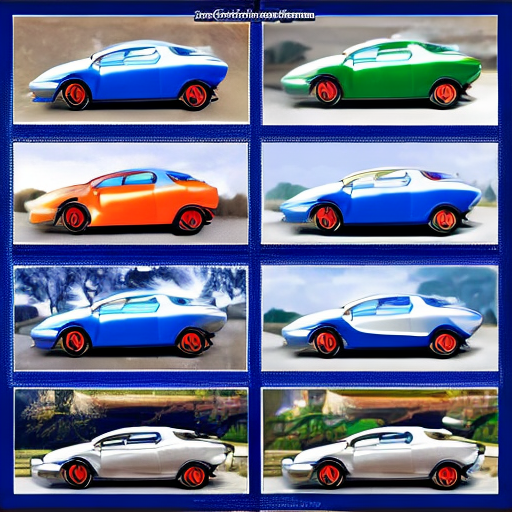

In [97]:
import cv2

prompt = "Create a claymorphism image on a white background. Picture of blue car with orange bow. Take the style from the start image"
PATH = '/kaggle/input/testing/bank_(24).png'
start_image = Image.fromarray(cv2.resize(cv2.imread(PATH), (512, 512), interpolation = cv2.INTER_LINEAR))
mask_image = Image.fromarray(cv2.resize(create_mask_image(PATH), (512, 512), interpolation = cv2.INTER_LINEAR).astype('uint8'), 'RGB')

image = pipe(prompt = prompt, image = start_image, mask_image = mask_image).images[0]
image

### С первой попытки качество вышло неудовлетворяющее